In [1]:
from __future__ import print_function
import math
import time
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
import system_of_units as units
import Nh5
import tblFunctions as tbl
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("Run last on {} at {}".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

Run last on 11/11/2016 at 11:38:16


In [2]:
try:
    f.close()
except:
    pass

In [3]:
f = tb.open_file("/Users/Gonzalo/github/IC/data/out0.h5")

In [4]:
print(f)

/Users/Gonzalo/github/IC/data/out0.h5 (File) ''
Last modif.: 'Mon Oct 24 00:16:03 2016'
Object Tree: 
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(500, 32000), shuffle, zlib(4)) ''
/BLR/pulse_on (EArray(500, 32000), shuffle, zlib(4)) ''
/BLR/wait_over (EArray(500, 32000), shuffle, zlib(4)) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
/MC/MCTracks (Table(4144,), zlib(1)) ''
/RD (Group) ''
/RD/pmtblr (EArray(500, 12, 32000), shuffle, zlib(4)) ''
/RD/pmtcwf (EArray(500, 12, 32000), shuffle, zlib(4)) ''
/RD/pmtrwf (EArray(500, 12, 32000), shuffle, zlib(4)) ''
/RD/sipmrwf (EArray(500, 1789, 800), shuffle, zlib(4)) ''
/Sensors (Group) ''
/Sensors/DataBLR (Table(12,)) ''
/Sensors/DataPMT (Table(12,)) ''
/Sensors/DataSiPM (Table(1789,)) ''
/TWF (Group) ''
/TWF/PMT (Table(7008,), shuffle, zlib(4)) 'Store for PMTs TWF'
/TWF/SiPM (Table(44112,), shuffle, zlib(4)) 'Store for SiPM TWF'
/ZS (Group) ''
/ZS/BLR (EArray(50

In [5]:
pmtzs = f.root.ZS.PMT
sipmzs = f.root.ZS.SiPM

# PMap definition (including Signal and Peak)

In [6]:
# WARNINGS:
# some input arguments need to be copied (for some reason I don't understand)
# otherwise, they will be taken from previous calls (wtf!?)

class Signal:
    """
    Structure to hold peak types.
    
    Attributes
    ----------
    UNKNOWN : string
        Unknown signal type.
    S1 : string
        S1 signal type.
    S2 : string
        S2 signal type.
    """
    UNKNOWN = "??"
    S1 = "S1"
    S2 = "S2"


class Peak:
    """
    A Peak is a collection of consecutive 1mus-slices containing both
    anode and cathode information.
    
    Parameters
    ----------
    times : 1-dim np.ndarray
        Time for each slice
    pmt_ene : 1-dim np.ndarray
        Signal recorded by the summed PMT for each slice
    sipm_enes : 2-dim np.ndarray
        Signal recorded by the SiPMs (axis 1) for each slice (axis 0)
    tothrs : 1-dim np.ndarray
        Number os 25ns-samples with signal for each slice
    peaktype : string, optional
        Peak type: Signal.S1, Signal.S2 or Signal.UNKNOWN
        default is Signal.UNKNOWN
    """
    
    def __init__(self, times, pmt_ene, sipm_enes, tothrs, peaktype=Signal.UNKNOWN):
        self.times = np.copy(times)
        self.cathode = np.copy(pmt_ene)
        self.anode = np.copy(sipm_enes)
        self.tothrs = np.copy(tothrs)
        self.signal = peaktype
        
        self.tmin = self.times[0]
        self.tmax = self.times[-1]
        self.width = self.tmax - self.tmin
        
        self.peakmax = self.times[np.argmax(self.cathode)], np.max(self.cathode)
        self.cathode_integral = self.cathode.sum()
        self.anode_integral = self.anode.sum()
        
    def __iter__(self):
        for data in zip(self.times, self.tothrs, self.cathode, self.anode):
            yield data
    
    def __str__(self):
        zs = lambda qs: [(ID, q) for ID, q in enumerate(qs) if q]
        header = "Peak type: {} Cathode sum: {} Anode sum: {}\n".format(self.signal,
                                                                        self.cathode_integral,
                                                                        self.anode_integral)
        header = header + "time ToT cathode anode\n"
        body = '\n'.join(["{} {} {} {}".format(t, tot, e, zs(q)) for t, tot, e, q in self])
        return header + body
    
    def __repr__(self):
        return str(self)


class PMap:
    """
    A PMap is a collection of peaks found in the same event.
    """
    def __init__(self, t0=-1., peaks=[]):
        self.t0 = t0
        self.peaks = list(peaks)
        
    def __str__(self):
        header = 'PMAP with {} peaks. Event t0 = {} mus'.format(len(self.peaks), self.t0)
        body = '\n'.join(['Peak #{}\n{}'.format(i, peak) for i, peak in enumerate(self.peaks)])
        return header + '\n\n' + body
    
    def __iter__(self):
        for peak in peaks:
            yield peak

    def __repr__(self):
        return str(self)


def build_pmap(pmtwf, sipmwfs, stride=40):
    """
    Finds any peak in the waveform and rebins it.
    """
    to_mus = 25*stride*units.ns/units.mus
    
    nbins = int(math.ceil(len(pmtwf)*1.0/stride))
    pmap = PMap()
    ene_pmt = []
    ene_sipms = []
    time_over_thrs = []
    tmin = float("inf")
    foundS2 = False
    
    for i in range(nbins):
        low = i * stride
        upp = low + stride
        slice_ = pmtwf[low:upp]
        e = slice_.sum()
        q = sipmwfs[:, i].flatten()
        t = i

        # Non-empty slice, append it and carry on
        if e > 0.:
            if t<tmin:
                tmin = t
            ene_pmt.append(e)
            q = np.concatenate((q,np.zeros(3)))
            ene_sipms.append(q)
            time_over_thrs.append(np.nonzero(slice_)[0].size)

        # Empty slice. Everything accumulated so far is a peak.
        # It will be S1-like if it is a short peak
        elif len(ene_pmt) > 0:
            sigtype = Signal.S2 if len(ene_pmt)>1 else Signal.S1 if not foundS2 else Signal.UNKNOWN
            if sigtype==Signal.S2:
                foundS2 = True
            tmax = t
            peak = Peak(np.arange(tmin, tmax)*to_mus,
                        ene_pmt, ene_sipms,
                        time_over_thrs, sigtype)
            pmap.peaks.append(peak)

            rebin_wf = []
            tmin = float("inf")
            ene_pmt = []
            ene_sipms = []
            time_over_thrs = []

    return pmap


def store_pmap(pmap, table, evt):
    row = table.row
    for i, peak in enumerate(pmap.peaks):
        for time, ToT, e, qs in peak:
            row["event"] = evt
            row["peak"] = i
            row["signal"] = peak.signal
            row["time"] = time
            row["ToT"] = ToT
            row["cathode"] = e
            row["anode"] = qs
            row.append()
    table.flush()
    

def read_pmap(table, evt):
    """
    Reads back the pmap stored in table.
    """
    pmap = PMap()
    peaks = set(table.read_where("event=={}".format(evt), field="peak"))
    for peak in peaks:
        coords = table.get_where_list("(event == {}) & "
                                      "(peak == {})".format(evt, peak))
        signal = table[coords[0]]["signal"]
        times = table.read_coordinates(coords, "time")
        ToT = table.read_coordinates(coords, "ToT")
        cathode = table.read_coordinates(coords, "cathode")
        anode = table.read_coordinates(coords, "anode")
        pmap.peaks.append(Peak(times, cathode, anode, ToT, signal))
    return pmap


# Test PMap creation

In [7]:
evt = 1
pmap = build_pmap(pmtzs[evt][0], sipmzs[evt])

In [8]:
print(pmap)

PMAP with 2 peaks. Event t0 = -1.0 mus

Peak #0
Peak type: S1 Cathode sum: 4 Anode sum: 0.0
time ToT cathode anode
100.0 2 4 []
Peak #1
Peak type: S2 Cathode sum: 10101 Anode sum: 531.0
time ToT cathode anode
380.0 5 9 []
381.0 31 141 [(1020, 5.0), (1280, 8.0)]
382.0 40 458 [(1020, 6.0), (1279, 7.0), (1280, 7.0), (1281, 4.0), (1288, 8.0)]
383.0 40 1113 [(1020, 9.0), (1279, 11.0), (1280, 38.0), (1281, 10.0), (1287, 5.0), (1288, 15.0)]
384.0 40 1875 [(1019, 8.0), (1020, 26.0), (1021, 6.0), (1279, 11.0), (1280, 42.0), (1281, 13.0), (1287, 5.0), (1288, 11.0)]
385.0 40 2221 [(1019, 11.0), (1020, 22.0), (1279, 14.0), (1280, 42.0), (1281, 11.0), (1287, 9.0), (1288, 18.0), (1289, 5.0)]
386.0 40 1949 [(1019, 4.0), (1020, 10.0), (1021, 4.0), (1279, 9.0), (1280, 43.0), (1281, 10.0), (1287, 4.0), (1288, 15.0)]
387.0 40 1312 [(1020, 5.0), (1279, 7.0), (1280, 17.0), (1281, 4.0)]
388.0 40 638 [(1280, 7.0), (1281, 5.0)]
389.0 40 316 []
390.0 29 69 []


# Test PMap IO

In [9]:
h5out = tb.open_file("pmap_test.h5", "w")
out_table = h5out.create_table(h5out.root, "PMAP", Nh5.PMAP, "Store for PMaps", tbl.filters("ZLIB4"))
store_pmap(pmap, out_table, 0)
h5out.close()
h5out = tb.open_file("pmap_test.h5")
pmap = read_pmap(h5out.root.PMAP, 0)
h5out.close()
print(pmap)

PMAP with 2 peaks. Event t0 = -1.0 mus

Peak #0
Peak type: S1 Cathode sum: 4.0 Anode sum: 0.0
time ToT cathode anode
100.0 2 4.0 []
Peak #1
Peak type: S2 Cathode sum: 10101.0 Anode sum: 531.0
time ToT cathode anode
380.0 5 9.0 []
381.0 31 141.0 [(1020, 5.0), (1280, 8.0)]
382.0 40 458.0 [(1020, 6.0), (1279, 7.0), (1280, 7.0), (1281, 4.0), (1288, 8.0)]
383.0 40 1113.0 [(1020, 9.0), (1279, 11.0), (1280, 38.0), (1281, 10.0), (1287, 5.0), (1288, 15.0)]
384.0 40 1875.0 [(1019, 8.0), (1020, 26.0), (1021, 6.0), (1279, 11.0), (1280, 42.0), (1281, 13.0), (1287, 5.0), (1288, 11.0)]
385.0 40 2221.0 [(1019, 11.0), (1020, 22.0), (1279, 14.0), (1280, 42.0), (1281, 11.0), (1287, 9.0), (1288, 18.0), (1289, 5.0)]
386.0 40 1949.0 [(1019, 4.0), (1020, 10.0), (1021, 4.0), (1279, 9.0), (1280, 43.0), (1281, 10.0), (1287, 4.0), (1288, 15.0)]
387.0 40 1312.0 [(1020, 5.0), (1279, 7.0), (1280, 17.0), (1281, 4.0)]
388.0 40 638.0 [(1280, 7.0), (1281, 5.0)]
389.0 40 316.0 []
390.0 29 69.0 []


# Timing PMap process

In [229]:
t0 = time.time()
pmaps = [build_pmap(pmtzs[evt][0],sipmzs[evt]) for evt in range(500)]
print(time.time()-t0)

17.0374040604


# Data study

### Histogram of the number of non-zero 25ns-samples in the same peak

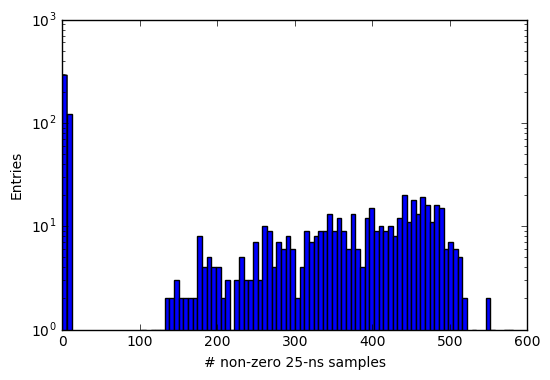

In [230]:
data = [pk.tothrs.sum() for pmap in pmaps for pk in pmap.peaks]
h = plt.hist(np.array(data).flatten(), 100, range=(0,600))
plt.xlabel("# non-zero 25-ns samples")
plt.ylabel("Entries")
plt.yscale("log")

### Histogram of the width of the peaks

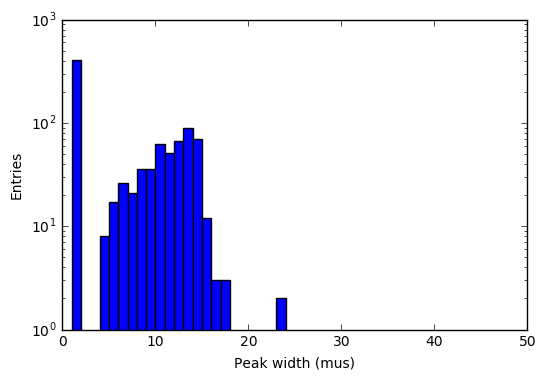

In [231]:
data = [pk.width for pmap in pmaps for pk in pmap.peaks]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.xlabel("Peak width (mus)")
plt.ylabel("Entries")
plt.yscale('log')

### Scatter plot of the number of non-zero samples vs width of the peaks

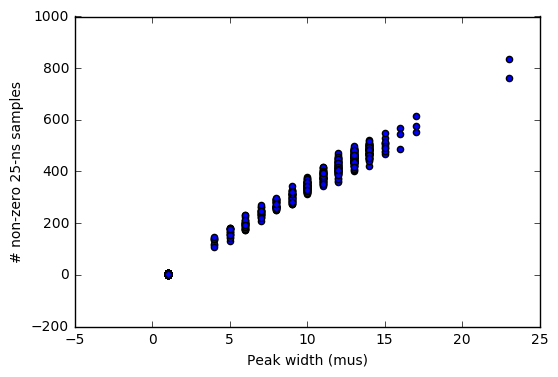

In [233]:
width, tot = zip(*[(pk.width, pk.tothrs.sum()) for pmap in pmaps for pk in pmap.peaks])
h = plt.scatter(width, tot)
plt.xlabel("Peak width (mus)")
plt.ylabel("# non-zero 25-ns samples")

### Histogram of the width of the peaks for non-zero samples < 20

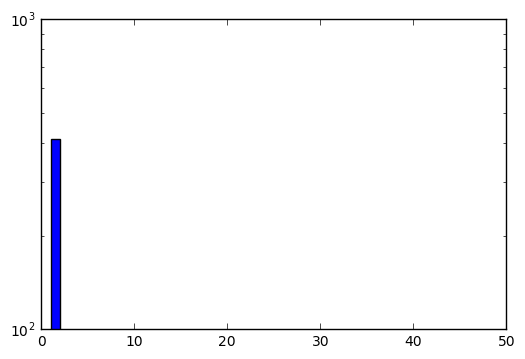

In [234]:
data = [pk.width for pmap in pmaps for pk in pmap.peaks if pk.tothrs.sum()<20]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.yscale('log')

### Histogram of the number of non-zero samples for 1-mus peaks

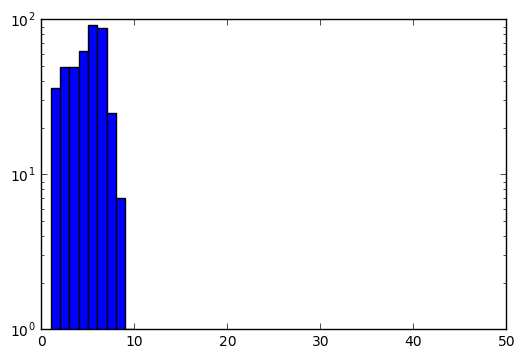

In [236]:
data = [pk.tothrs.sum() for pmap in pmaps for pk in pmap.peaks if pk.width==1.]
h = plt.hist(np.array(data).flatten(), 50, range=(0,50))
plt.yscale('log')

**S1 can be defined based on the # of non-zero samples or the peak width**